# (가제) 파이썬 데이터 분석

# 3.3) 미래에 볼 영화의 평점 예측하기

### 바로가기

- [<Step1. 탐색> : MovieLens 데이터 살펴보기](#<Step1.-탐색>-:-MovieLens-데이터-살펴보기)
    - [MovieLens 데이터셋의 기본 정보]
- [<Step2. 분석> : 탐색적 데이터 분석](#<Step2.-분석>-:-탐색적-데이터-분석)
    - [분석할 영화의 정보 탐색하기]
    - [장르의 속성 탐색]
    - [분석할 유저의 정보 탐색하기]
    - [평점 데이터의 정보 탐색하기]
    - [user-movie 형태의 테이블로 살펴보기]
- [<Step3. 예측> : 수학적 기법을 활용한 평점 예측](#<Step3.-예측>-:-수학적-기법을-활용한-평점-예측)
    - [SVD를 활용한 빈칸 채우기]
    - [아직 평가하지 않은 영화의 점수 예측하기]
- [<Step4. 평가> : 예측 모델 평가하기](#<Step4.-평가>-:-예측-모델-평가하기)
    - [예측 모델의 평가 방법]
    - [실제 평점과의 비교 시각화]
    - [한걸음 더 : 20대가 좋아할만한 영화를 예측해보자]

-----

In [1]:
# -*- coding: utf-8 -*-

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : MovieLens 데이터 살펴보기

### [MovieLens 데이터셋의 기본 정보]

In [3]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../python-data-analysis-master/data/ml-1m/ratings.dat"
movie_file_path = "../python-data-analysis-master/data/ml-1m/movies.dat"
user_file_path = "../python-data-analysis-master/data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, encoding="ISO-8859-1",
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, encoding="ISO-8859-1",
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, encoding="ISO-8859-1",
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [5]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


-----

In [6]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


-----

In [7]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


-----

# <Step2. 분석> : 탐색적 데이터 분석

### [분석할 영화의 정보 탐색하기]

In [8]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

-----

In [9]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


-----

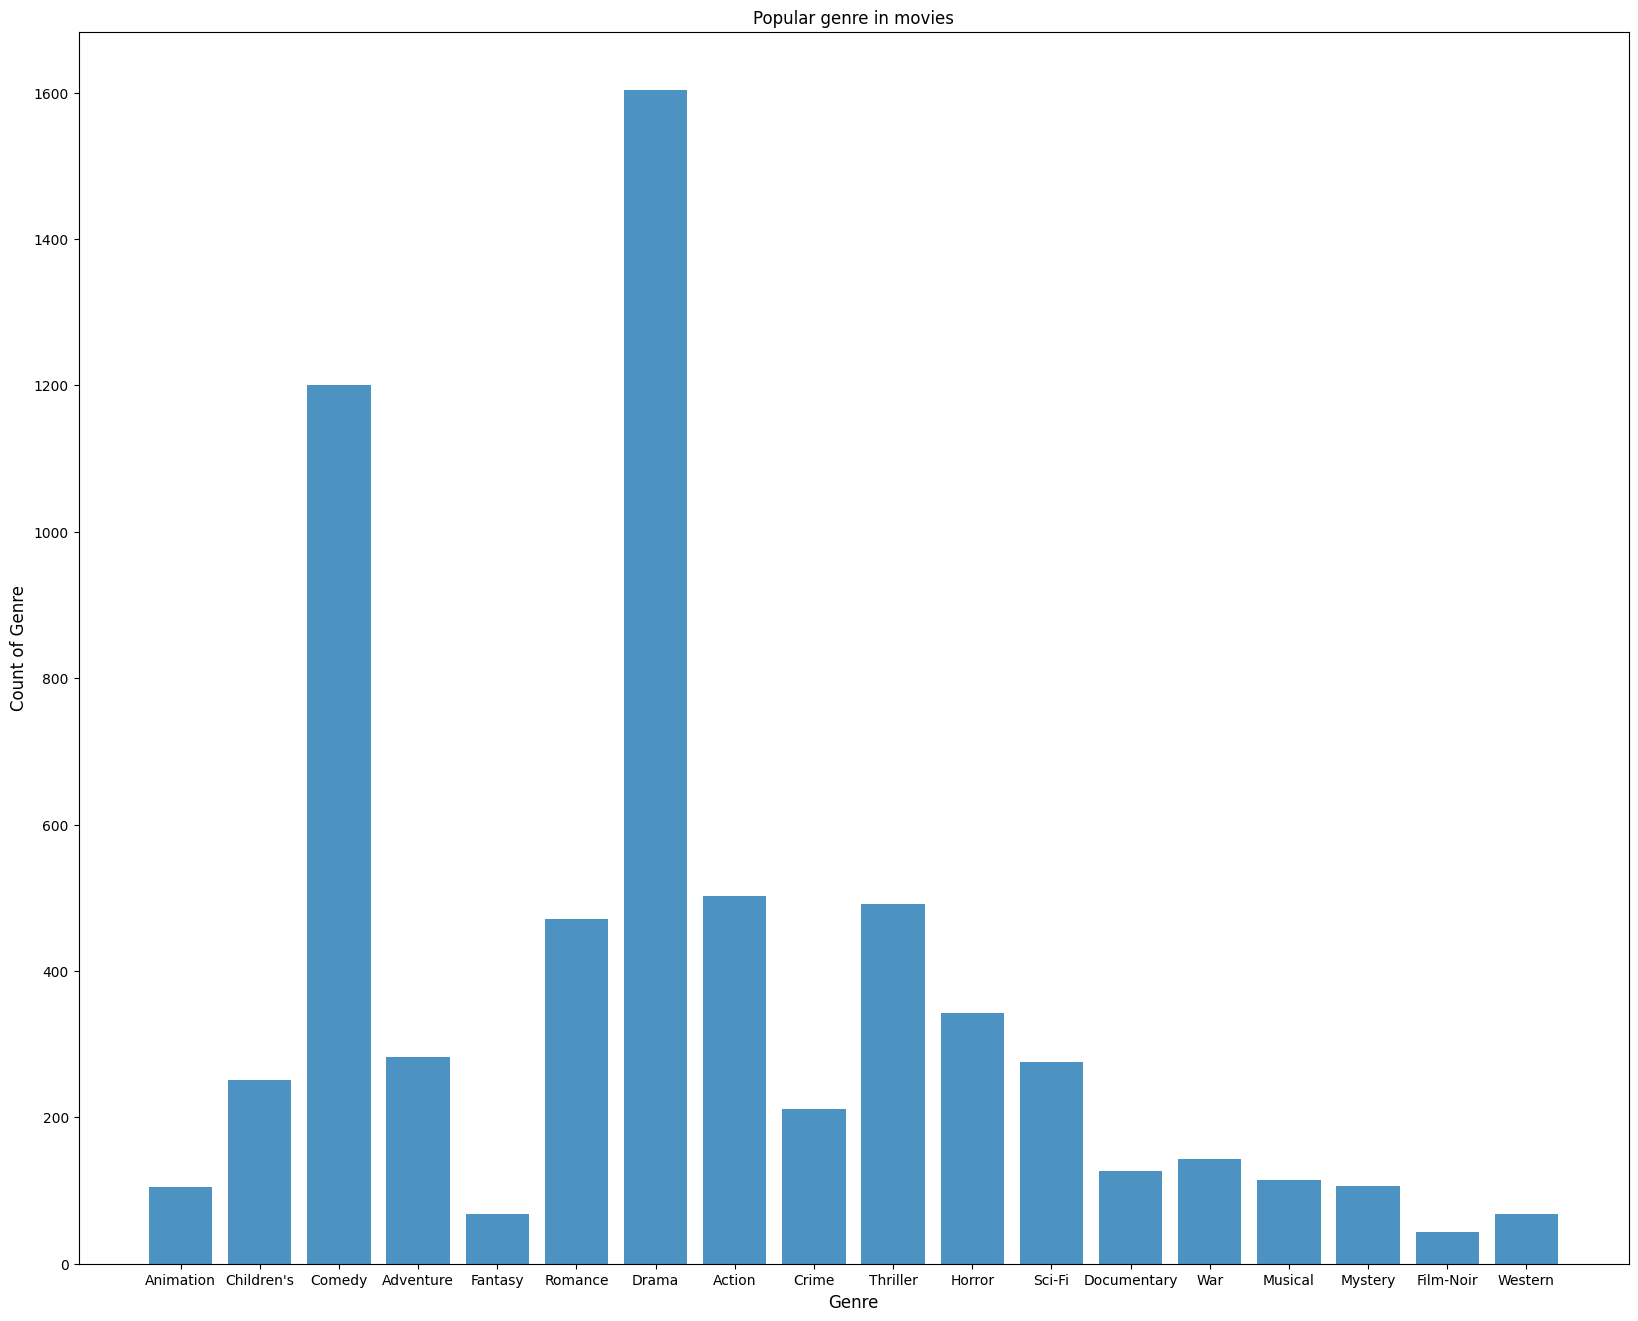

In [14]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
plt.bar(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

In [15]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


-----

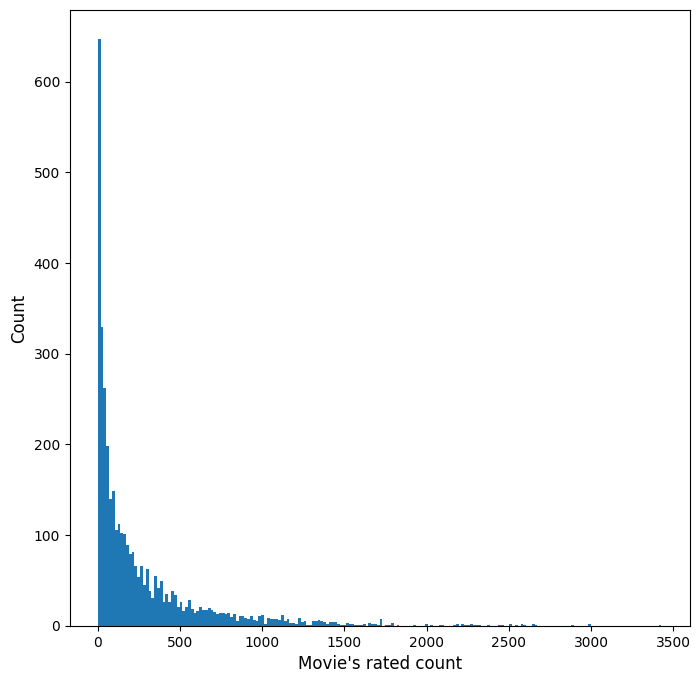

In [16]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [17]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


-----

In [19]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [20]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot: >

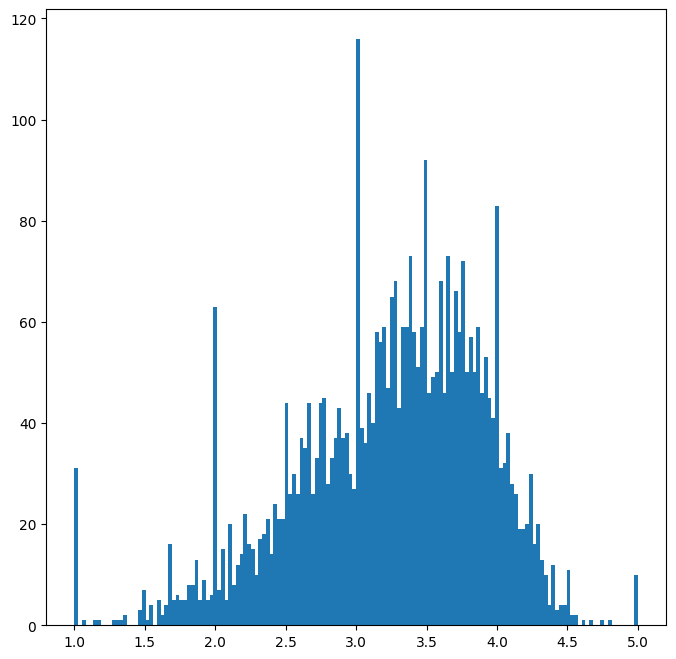

In [21]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

-----

### [user-movie 형태의 표로 살펴보기]

In [22]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

-----

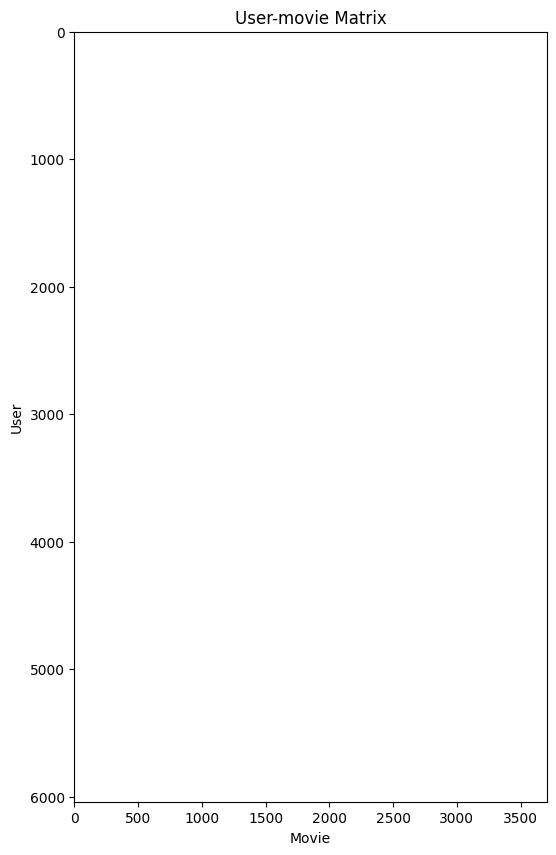

In [23]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

# <Step3. 예측> : 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) `pip install surprise`

-----

In [24]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

-----

### [아직 평가하지 않은 영화의 점수 예측하기]

##### MovieLens 데이터에 SVD 적용하기

In [25]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 10.25 seconds


-----

##### 영화의 점수를 예측할 타겟 유저 선정

In [26]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [31]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


-----

##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [34]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [35]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [36]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [37]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(111, 5),
 (246, 5),
 (326, 5),
 (527, 5),
 (567, 5),
 (602, 5),
 (608, 5),
 (615, 5),
 (669, 5),
 (670, 5)]

In [38]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [39]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Taxi Driver (1976) : 5
Hoop Dreams (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Kika (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
World of Apu, The (Apur Sansar) (1959) : 5


In [40]:
# 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


-----

# <Step4. 평가> : 예측 모델 평가하기

### [예측 모델의 평가 방법]

##### RMSE 계산하기

In [41]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 17.38 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8580


0.857989655716057

-----

##### 평점 예측 단계

In [42]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [43]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [44]:
target_user_movie_predict_dict

{260: 4.100985629029007,
 480: 3.658882589827914,
 1036: 4.20824228240389,
 1097: 4.2082390321298915,
 1196: 3.7820877844569654,
 1198: 4.3333942670685754,
 1201: 4.585201259610477,
 1210: 3.2572337474659214,
 1214: 4.298758879464518,
 1240: 4.050491013676777,
 1387: 4.538549145326632,
 1954: 4.265741876464118,
 2028: 4.498898528407791,
 2366: 4.03877389210256,
 2692: 4.200878368839405,
 2947: 4.06393952956487,
 2951: 4.25733345029744,
 3418: 4.3746394702220694,
 3468: 4.914153959537585,
 3527: 3.1040876207873977,
 3702: 3.4277882202967653}

In [45]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.1
movie 2 : Jurassic Park (1993) - 4 / 3.66
movie 3 : Die Hard (1988) - 4 / 4.21
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.21
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.78
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.33
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.59
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.26
movie 9 : Alien (1979) - 4 / 4.3
movie 10 : Terminator, The (1984) - 5 / 4.05
movie 11 : Jaws (1975) - 5 / 4.54
movie 12 : Rocky (1976) - 5 / 4.27
movie 13 : Saving Private Ryan (1998) - 5 / 4.5
movie 14 : King Kong (1933) - 4 / 4.04
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.2
movie 16 : Goldfinger (1964) - 5 / 4.06
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.26
movie 18 : Thelma & Louise (1991) - 4 / 4.37
movie 19 : Hustler, The (1961) - 5 / 4.91
movie 20 : Predator (1987) - 1 / 3.1
movie 21 : Mad Max (1979) - 4 / 3.43


-----